In [3]:
import math
from random import shuffle
from copy import deepcopy
import torch
import torch.nn.functional as tfunc
import matplotlib.pyplot as plt


torch.set_default_device("cuda")

# Building Dataset

In [4]:
words = open("../names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
char_to_indx = {char: indx+1 for indx, char in enumerate(chars)}
char_to_indx["."] = 0
indx_to_char = {indx: char for char, indx in char_to_indx.items()}

def train_dev_test_split(words, train_percentage, dev_percentage):
    shuffled_words = deepcopy(words)
    shuffle(shuffled_words)
    train_dev_split_point = math.ceil(len(words) * train_percentage)
    dev_val_split_point = math.floor(
        train_dev_split_point + (len(words) * dev_percentage)
    )
    return (
        shuffled_words[:train_dev_split_point],
        shuffled_words[train_dev_split_point:dev_val_split_point],
        shuffled_words[dev_val_split_point:],
    )

def create_dataset(words, char_to_indx, block_size = 3):
    inputs, labels = [], []
    for word in words:
        # print(word)
        context = [0] * block_size
        for label in word + ".":
            label_indx = char_to_indx[label]
            inputs.append(context)
            labels.append(label_indx)
            # print("".join(indx_to_char[indx] for indx in context), "------>", label)
            context = context[1:] + [label_indx]
        # print()

    return torch.tensor(inputs), torch.tensor(labels)

BLOCK_SIZE = 5
train_words, dev_words, test_words = train_dev_test_split(words, 0.8, 0.1)
train_inputs, train_labels = create_dataset(train_words, char_to_indx, block_size=BLOCK_SIZE)
dev_inputs, dev_labels = create_dataset(dev_words, char_to_indx, block_size=BLOCK_SIZE)
test_inputs, test_labels = create_dataset(test_words, char_to_indx, block_size=BLOCK_SIZE)

# Initializing Model Params

In [ ]:
# Params
gen = torch.Generator(device="cuda").manual_seed(2147483647)
CHAR_FEATURES_NUM = 30
HIDDEN_UNITS_NUM = 300

# Randomly generated params
C = torch.randn((27, CHAR_FEATURES_NUM), generator=gen, requires_grad=True) # Lookup table
weights1 = torch.randn((BLOCK_SIZE * CHAR_FEATURES_NUM, HIDDEN_UNITS_NUM), generator=gen, requires_grad=True)
bias1 = torch.randn(HIDDEN_UNITS_NUM, generator=gen, requires_grad=True)
weights2 = torch.randn((HIDDEN_UNITS_NUM, 27), generator=gen, requires_grad=True)
bias2 = torch.randn(27, generator=gen, requires_grad=True)

# Uniform params
C = torch.ones((27, CHAR_FEATURES_NUM), requires_grad=True) # Lookup table
weights1 = torch.ones((BLOCK_SIZE * CHAR_FEATURES_NUM, HIDDEN_UNITS_NUM), requires_grad=True)
bias1 = torch.ones(HIDDEN_UNITS_NUM, requires_grad=True)
weights2 = torch.ones((HIDDEN_UNITS_NUM, 27), requires_grad=True)
bias2 = torch.ones(27, requires_grad=True)

parameters = [C, weights1, bias1, weights2, bias2]
print(f"TOTAL PARAMS: {sum([param.nelement() for param in parameters])}")

TOTAL PARAMS: 54237


# Training Model

In [ ]:
EPOCHS = 250000
MINI_BATCH_SIZE = 50
THIRD_OF_EPOCH = EPOCHS // 3

losses = []
learning_rate = 0.1
for indx in range(0, EPOCHS):
    mini_batch_indxs = torch.randint(0, train_inputs.shape[0], (MINI_BATCH_SIZE,))
    mini_batch_inputs = train_inputs[mini_batch_indxs]
    mini_batch_labels = train_labels[mini_batch_indxs]

    embed = C[mini_batch_inputs]
    joined_embed = embed.view(embed.shape[0], embed.shape[1] * embed.shape[2])
    layer1_out = torch.tanh(joined_embed @ weights1 + bias1)
    logits = layer1_out @ weights2 + bias2
    loss = tfunc.cross_entropy(logits, mini_batch_labels)

    for param in parameters:
        param.grad = None

    if THIRD_OF_EPOCH < indx < 2 * THIRD_OF_EPOCH:
        learning_rate = 0.01 
    elif 2 * THIRD_OF_EPOCH < indx:
        learning_rate = 0.001 

    loss.backward()
    for param in parameters:
        param.data += learning_rate * -param.grad
    
    losses.append(loss.log10().item())

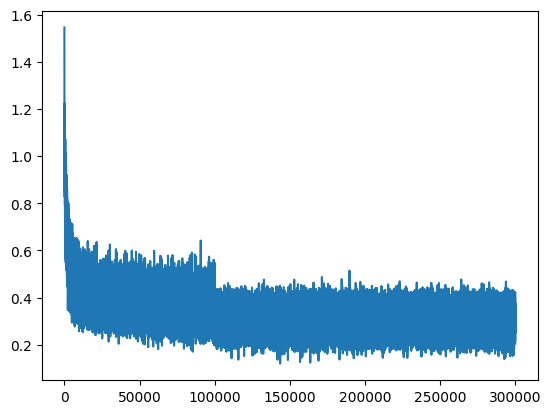

In [54]:
plt.plot(list(range(EPOCHS)), losses)

# Eval Model with Dev Data

In [55]:
embed = C[train_inputs]
joined_embed = embed.view(embed.shape[0], embed.shape[1] * embed.shape[2])
layer1_out = torch.tanh(joined_embed @ weights1 + bias1)
logits = layer1_out @ weights2 + bias2
loss = tfunc.cross_entropy(logits, train_labels)
print(f"Train loss: {loss.item()}")

embed = C[dev_inputs]
joined_embed = embed.view(embed.shape[0], embed.shape[1] * embed.shape[2])
layer1_out = torch.tanh(joined_embed @ weights1 + bias1)
logits = layer1_out @ weights2 + bias2
loss = tfunc.cross_entropy(logits, dev_labels)
print(f"Dev loss: {loss.item()}")

Train loss: 2.0467352867126465
Dev loss: 2.197509288787842


In [ ]:
# Best train loss: 2.1013004779815674
# Best dev loss: 2.195601224899292